In [1]:
import numpy as np
import pandas as pd
from preprocess import preprocess  # local file. restart kernel if this changed, it won't be re-imported otherwise
from sklearn.model_selection import train_test_split

## Read the first few rows during crude developing:
#train = pd.read_csv('../data/train.csv', nrows=10000).fillna(' ')  # train has 159571 comments
#test = pd.read_csv('../data/test.csv', nrows=1000).fillna(' ')

## These lines load all data:
train = pd.read_csv('../data/train.csv').fillna(' ')
test = pd.read_csv('../data/test.csv').fillna(' ')

[train, test, train_text, test_text, all_text, class_names] = preprocess(train, test)

# Remove 80% of the train set's comments that are all-ok to counter the imbalancedness a bit
#delete_idx = (train[class_names].sum(axis = 1) == 0) & (np.random.rand(len(train)) > 0.2)
#keep_idx = ~delete_idx  # elem-wise NOT for pd.Series
#train = train[keep_idx]

In [2]:
# I want a fixed 5000 observations in the test set. Adapt the fraction accordingly:
test_fraction = 5000 / len(train)

train, dev = train_test_split(train, test_size=test_fraction, random_state=42)
# Reset indices because they were shuffled and I need them from 0 to len()
train.index = list(range(len(train)))
dev.index = list(range(len(dev)))

In [3]:
# either:
#max_len_train = train['comment_text'].str.split().apply(len).max()
#max_len_test = test['comment_text'].str.split().apply(len).max()
#max_len = max(max_len_train, max_len_test)

# or:
max_len = 250  # that might work to have shorter LSTM cells

In [15]:
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, GRU, Activation, Flatten, Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

In [5]:
## set number of cores to 8
#from keras import backend as K
#import tensorflow as tf

#config = tf.ConfigProto(intra_op_parallelism_threads=8,
#                        inter_op_parallelism_threads=8,
#                        allow_soft_placement=True, 
#                        device_count = {'CPU': 8})
#session = tf.Session(config=config)
#K.set_session(session)

In [6]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [7]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('../data/glove.6B.50d.txt')

In [8]:
import re

def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = re.sub(r"\W", " ", X[i]).lower().split()

        n_words = len(sentence_words)
        
        if n_words > max_len:  # use the *beginning* of the comment if it's too long
            sentence_words = sentence_words[0:max_len]
            n_words = max_len

        ctr = 0
        
        for w in sentence_words:
            j = max_len - n_words + ctr 
            
            if w in word_to_index:
                # pad sequences from the left, i.e. start so the "last" word in the comment is the max_len'th entry.
                X_indices[i, j] = word_to_index[w]
                
            ctr += 1
            
            if j >= max_len:  
                # adding this clause, you can have sentences longer than max_len and crop them
                break
    
    return X_indices

In [ ]:
X_train_indices = sentences_to_indices(train['comment_text'], word_to_index, max_len)
Y_train = train[class_names].values
X_dev_indices = sentences_to_indices(dev['comment_text'], word_to_index, max_len)
Y_dev = dev[class_names].values

In [9]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)#, mask_zero = True)

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [10]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

In [54]:
def myModel(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    #embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    X = embedding_layer(sentence_indices)   
    
    X = Conv1D(8, 5, activation = 'relu')(X)
    X = MaxPooling1D(5)(X)
    X = Dropout(0.2)(X)
    X = Conv1D(32, 5, activation = 'relu')(X)
    X = MaxPooling1D(5)(X)
    X = Dropout(0.2)(X)
    X = Flatten()(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(units = 6, activation = 'sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs = sentence_indices, outputs = X)
    
    return model

In [55]:
model = myModel((max_len,), word_to_vec_map, word_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 250)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 250, 50)           20000050  
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 246, 8)            2008      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 49, 8)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 49, 8)             0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 45, 32)            1312      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 9, 32)             0         
__________

## Waarschuwing

If you pad your sequences from the right instead the left, the model outputs same predictions for each sample!

There might be a vanishing gradients problem?

In [57]:
# # their tokenizer (creates its own indices though, that don't fit with the GloVe embedding)

# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences


# #max_features = 20000
# max_features = 400000

# tokenizer = Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(list(train['comment_text']))
# list_tokenized_train = tokenizer.texts_to_sequences(train['comment_text'])
# list_tokenized_test = tokenizer.texts_to_sequences(test['comment_text'])
# maxlen = 200
# X_train_indices = pad_sequences(list_tokenized_train, maxlen=maxlen, padding = 'pre')
# X_test_indices = pad_sequences(list_tokenized_test, maxlen=maxlen)

# X_train_indices[0]

In [58]:
#from keras import optimizers
#adam_gradclip = optimizers.Adam(clipnorm = 1, clipvalue = 0.5)

In [59]:
# model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
# if you want to save a model's configuration and weights, and train it further tomorrow:

#from keras.models import load_model
#model = load_model("07-model-cnn.h5")

In [61]:
import matplotlib.pyplot as plt

In [76]:
history = model.fit(X_train_indices, Y_train, epochs = 1, batch_size = 32, shuffle=True,
                   validation_data = (X_dev_indices, Y_dev))
model.save("07-model-cnn.h5")

Train on 154571 samples, validate on 5000 samples
Epoch 1/1
154571/154571 [==============================] - 266s 2ms/step - loss: 0.0752 - acc: 0.9748 - val_loss: 0.0733 - val_acc: 0.9761


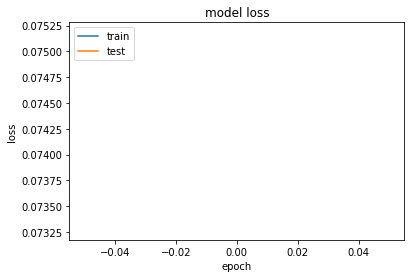

In [77]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [78]:
from sklearn import metrics

m = 5000

pred_train = model.predict(X_train_indices[0:m, :])  # train performance on first 5k samples only...
aucs = np.zeros((len(class_names)))

for y_i in range(len(class_names)):
    y = Y_train[0:m, y_i]
    yhat = pred_train[0:m, y_i]
    fpr, tpr, thresholds = metrics.roc_curve(y, yhat, pos_label = 1)
    this_auc = metrics.auc(fpr, tpr)
    aucs[y_i] = this_auc
    
np.mean(aucs)

0.9530727938506051

Full run:

- 10 epochs w/ dropout: 0.9804661203849432

# Compute dev set mean AUC

In [79]:
%%time

# model.evaluate(X_dev_indices, Y_dev, batch_size = len(train))
pred_dev = model.predict(X_dev_indices)

CPU times: user 4.67 s, sys: 1.58 s, total: 6.26 s
Wall time: 2.63 s


In [80]:
aucs = np.zeros((len(class_names)))

for y_i in range(len(class_names)):
    y = Y_dev[:, y_i]
    yhat = pred_dev[:, y_i]
    fpr, tpr, thresholds = metrics.roc_curve(y, yhat, pos_label = 1)
    this_auc = metrics.auc(fpr, tpr)
    aucs[y_i] = this_auc
    
np.mean(aucs)

0.9314876016565482

Full run:

- 10 epochs with dropout: 0.937659986918144

# Sanity check train predictions

In [25]:
pred = model.predict(X_train_indices[0:7, :])  # the 7th comment (in unshuffled train) is a very toxic doggo

In [26]:
pred

array([[6.3497241e-04, 1.4876262e-09, 3.9197319e-05, 6.5515977e-08,
        3.1774027e-05, 7.7998777e-07],
       [1.3203488e-03, 1.2483348e-09, 5.7818586e-05, 4.6398277e-08,
        4.8434984e-05, 1.0442246e-06],
       [6.1643816e-04, 3.1910000e-10, 1.8953759e-05, 7.3298008e-09,
        1.7444301e-05, 2.0307276e-07],
       [5.0278148e-04, 3.2158740e-10, 1.5368229e-05, 1.2597208e-08,
        1.2031453e-05, 1.9660762e-07],
       [1.0031880e-01, 2.6487714e-05, 1.6511204e-02, 1.2358227e-04,
        1.4168523e-02, 9.5172826e-04],
       [6.9022202e-04, 7.9367757e-10, 2.7619690e-05, 2.4291433e-08,
        2.0929217e-05, 3.7219368e-07],
       [9.2507827e-01, 2.0645539e-01, 7.3372906e-01, 8.5256480e-02,
        6.2058413e-01, 2.2601873e-01]], dtype=float32)

# Create submission csv

In [26]:
X_test_indices = sentences_to_indices(test['comment_text'], word_to_index, max_len)
pred = model.predict(X_test_indices)
submit = pd.DataFrame(test['id'].values, columns=['id'])
preds = pd.DataFrame(pred, columns=class_names)
submit = pd.concat([submit, preds], axis = 1)
#submit
submit.to_csv('../data/submission_07_cnn.csv', index = False)